In [2]:
# Cell 1 — Setup path

import os
import sys
from pathlib import Path

# Notebook ada di folder "notebooks"
ROOT_DIR = Path("..").resolve()

if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

print("ROOT_DIR :", ROOT_DIR)
print("Isi ROOT_DIR :", os.listdir(ROOT_DIR))


ROOT_DIR : C:\Kuliah ITS Farhan\Semester 3\A_Final_Project\FP_KK\fp_kk_11_early_warning_hoax
Isi ROOT_DIR : ['.env', '.git', '.gitignore', '.venv', 'app', 'data', 'notebooks', 'README.md', 'requirements.txt', 'src']


In [3]:
# Cell 2 — import fungsi dari src

import numpy as np
import pandas as pd

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

from src.fuzzy_system import hitung_resiko_hoaks, hitung_resiko_hoaks_pso
from src.llm_features import hitung_skor_llm_df
from src.pso_optimizer import BEST_W_PSO

print("BEST_W_PSO :", BEST_W_PSO)


BEST_W_PSO : [0.5        1.5        1.33333334]


In [4]:
# Cell 3 — definisi skenario caption (A/B/C)

data_skenario = [
    # ===== Kelompok A: variasi emosi =====
    {
        "id": "A1",
        "kelompok": "A_emosi",
        "deskripsi": "Netral",
        "caption": (
            "Pemerintah mengumumkan penyesuaian harga BBM mulai bulan depan. "
            "Detail kebijakan dapat dibaca di situs resmi kementerian."
        ),
    },
    {
        "id": "A2",
        "kelompok": "A_emosi",
        "deskripsi": "Agak emosional",
        "caption": (
            "Harga BBM akan naik lagi bulan depan. Banyak warga khawatir, "
            "tapi pemerintah menyebut kebijakan ini sudah dipertimbangkan matang."
        ),
    },
    {
        "id": "A3",
        "kelompok": "A_emosi",
        "deskripsi": "Sangat emosional / provokatif",
        "caption": (
            "BBM NAIK LAGI! RAKYAT MAKIN SENGSARA, PEMERINTAH DIAM SAJA! "
            "SEBARKAN BIAR SEMUA TAHU KEZALIMAN INI!!!"
        ),
    },

    # ===== Kelompok B: variasi format pesan =====
    {
        "id": "B1",
        "kelompok": "B_format",
        "deskripsi": "Format berita biasa",
        "caption": (
            "Beberapa wilayah dilaporkan mengalami banjir bandang. "
            "Warga diminta waspada dan mengikuti arahan resmi dari BPBD setempat."
        ),
    },
    {
        "id": "B2",
        "kelompok": "B_format",
        "deskripsi": "Semi broadcast",
        "caption": (
            "INFO BANJIR: beberapa wilayah kena banjir bandang.\n"
            "Mohon waspada, simpan barang penting, dan cek info dari BPBD / grup RT."
        ),
    },
    {
        "id": "B3",
        "kelompok": "B_format",
        "deskripsi": "Broadcast hoaks klasik",
        "caption": (
            "⛔⛔⛔ PENTING!!!\n"
            "SEMUA WARGA WAJIB KELUAR DARI RUMAH MALAM INI!!!\n"
            "BANJIR BESAR AKAN DATANG MENURUT INFO ORANG DALAM!!!\n"
            "SEBARKAN KE 10 GRUP ATAU ANDA AKAN MENYESAL!!!"
        ),
    },

    # ===== Kelompok C: variasi kredibilitas profil (disimulasikan di teks) =====
    {
        "id": "C1",
        "kelompok": "C_kred",
        "deskripsi": "Profil sangat kredibel (lembaga resmi)",
        "caption": (
            "[Akun resmi BMKG]\n"
            "BMKG mengeluarkan peringatan dini cuaca untuk besok. "
            "Informasi lengkap tersedia di website dan kanal resmi BMKG."
        ),
    },
    {
        "id": "C2",
        "kelompok": "C_kred",
        "deskripsi": "Profil netral (akun pribadi jelas)",
        "caption": (
            "[Akun warga biasa]\n"
            "Saya baca info BMKG soal cuaca besok, kemungkinan hujan lebat. "
            "Teman-teman sebaiknya hati-hati kalau beraktivitas di luar."
        ),
    },
    {
        "id": "C3",
        "kelompok": "C_kred",
        "deskripsi": "Profil meragukan / anonim",
        "caption": (
            "[Akun anonim]\n"
            "CUACA BESOK KATANYA BAHAYA BANGET TAPI BERITA INI DISEMBUNYIKAN!!! "
            "CUMA ORANG DALAM YANG TAU, SEBARKAN SEBELUM DIHAPUS!!!"
        ),
    },
]

df_skenario_raw = pd.DataFrame(data_skenario)
df_skenario_raw


,id,kelompok,deskripsi,caption
0,A1,A_emosi,Netral,Pemerintah mengumumkan penyesuaian harga BBM m...
1,A2,A_emosi,Agak emosional,Harga BBM akan naik lagi bulan depan. Banyak w...
2,A3,A_emosi,Sangat emosional / provokatif,"BBM NAIK LAGI! RAKYAT MAKIN SENGSARA, PEMERINT..."
3,B1,B_format,Format berita biasa,Beberapa wilayah dilaporkan mengalami banjir b...
4,B2,B_format,Semi broadcast,INFO BANJIR: beberapa wilayah kena banjir band...
5,B3,B_format,Broadcast hoaks klasik,⛔⛔⛔ PENTING!!!\nSEMUA WARGA WAJIB KELUAR DARI ...
6,C1,C_kred,Profil sangat kredibel (lembaga resmi),[Akun resmi BMKG]\nBMKG mengeluarkan peringata...
7,C2,C_kred,Profil netral (akun pribadi jelas),[Akun warga biasa]\nSaya baca info BMKG soal c...
8,C3,C_kred,Profil meragukan / anonim,[Akun anonim]\nCUACA BESOK KATANYA BAHAYA BANG...


In [9]:
# Cell 4 — hitung skor LLM untuk setiap caption skenario
# Pastikan .env sudah berisi GOOGLE_API_KEY
# dan fungsi hitung_skor_llm_df sudah benar mengeluarkan 3 skor tersebut

df_skenario_llm = hitung_skor_llm_df(
    df_skenario_raw.copy(),
    text_col="caption",   # sesuaikan jika parameternya beda di file kamu
)

df_skenario_llm[
    [
        "id",
        "kelompok",
        "deskripsi",
        "intensitas_emosi",
        "kecurigaan_format",
        "kredibilitas_rendah",
    ]
]


,id,kelompok,deskripsi,intensitas_emosi,kecurigaan_format,kredibilitas_rendah
0,A1,A_emosi,Netral,0.1,0.0,0.0
1,A2,A_emosi,Agak emosional,0.5,0.0,0.5
2,A3,A_emosi,Sangat emosional / provokatif,1.0,1.0,0.9
3,B1,B_format,Format berita biasa,0.3,0.0,0.0
4,B2,B_format,Semi broadcast,0.6,0.2,0.4
5,B3,B_format,Broadcast hoaks klasik,1.0,1.0,1.0
6,C1,C_kred,Profil sangat kredibel (lembaga resmi),0.1,0.0,0.0
7,C2,C_kred,Profil netral (akun pribadi jelas),0.3,0.0,0.3
8,C3,C_kred,Profil meragukan / anonim,1.0,1.0,1.0


In [10]:
# Cell 5 — hitung resiko_hoaks (Fuzzy & Fuzzy+PSO)

df_skenario = df_skenario_llm.copy()

def fuzzy_row(row):
    return hitung_resiko_hoaks(
        intensitas_emosi=row["intensitas_emosi"],
        kecurigaan_format=row["kecurigaan_format"],
        kredibilitas_rendah=row["kredibilitas_rendah"],
        output_scale_100=True,
    )

def fuzzy_pso_row(row):
    return hitung_resiko_hoaks_pso(
        intensitas_emosi=row["intensitas_emosi"],
        kecurigaan_format=row["kecurigaan_format"],
        kredibilitas_rendah=row["kredibilitas_rendah"],
        weights=BEST_W_PSO,
        output_scale_100=True,
    )

df_skenario["resiko_fuzzy"] = df_skenario.apply(fuzzy_row, axis=1)
df_skenario["resiko_fuzzy_pso"] = df_skenario.apply(fuzzy_pso_row, axis=1)

df_skenario[
    [
        "id",
        "kelompok",
        "deskripsi",
        "intensitas_emosi",
        "kecurigaan_format",
        "kredibilitas_rendah",
        "resiko_fuzzy",
        "resiko_fuzzy_pso",
    ]
]


,id,kelompok,deskripsi,intensitas_emosi,kecurigaan_format,kredibilitas_rendah,resiko_fuzzy,resiko_fuzzy_pso
0,A1,A_emosi,Netral,0.1,0.0,0.0,13.859736,13.368132
1,A2,A_emosi,Agak emosional,0.5,0.0,0.5,13.166667,30.906025
2,A3,A_emosi,Sangat emosional / provokatif,1.0,1.0,0.9,86.140264,86.833333
3,B1,B_format,Format berita biasa,0.3,0.0,0.0,17.492908,14.563063
4,B2,B_format,Semi broadcast,0.6,0.2,0.4,15.425620,39.900735
5,B3,B_format,Broadcast hoaks klasik,1.0,1.0,1.0,86.833333,86.833333
6,C1,C_kred,Profil sangat kredibel (lembaga resmi),0.1,0.0,0.0,13.859736,13.368132
7,C2,C_kred,Profil netral (akun pribadi jelas),0.3,0.0,0.3,16.761307,14.563063
8,C3,C_kred,Profil meragukan / anonim,1.0,1.0,1.0,86.833333,86.833333


In [11]:
# Cell 6 — ringkasan tabel per kelompok agar enak dipakai di laporan

summary_list = []

for g, dfg in df_skenario.groupby("kelompok"):
    for _, row in dfg.iterrows():
        summary_list.append(
            {
                "Kelompok": g,
                "ID": row["id"],
                "Deskripsi": row["deskripsi"],
                "intensitas_emosi": round(row["intensitas_emosi"], 3),
                "kecurigaan_format": round(row["kecurigaan_format"], 3),
                "kredibilitas_rendah": round(row["kredibilitas_rendah"], 3),
                "resiko_fuzzy": round(row["resiko_fuzzy"], 2),
                "resiko_fuzzy_pso": round(row["resiko_fuzzy_pso"], 2),
            }
        )

df_summary_exp3 = pd.DataFrame(summary_list)
df_summary_exp3


,Kelompok,ID,Deskripsi,intensitas_emosi,kecurigaan_format,kredibilitas_rendah,resiko_fuzzy,resiko_fuzzy_pso
0,A_emosi,A1,Netral,0.1,0.0,0.0,13.86,13.37
1,A_emosi,A2,Agak emosional,0.5,0.0,0.5,13.17,30.91
2,A_emosi,A3,Sangat emosional / provokatif,1.0,1.0,0.9,86.14,86.83
3,B_format,B1,Format berita biasa,0.3,0.0,0.0,17.49,14.56
4,B_format,B2,Semi broadcast,0.6,0.2,0.4,15.43,39.90
5,B_format,B3,Broadcast hoaks klasik,1.0,1.0,1.0,86.83,86.83
6,C_kred,C1,Profil sangat kredibel (lembaga resmi),0.1,0.0,0.0,13.86,13.37
7,C_kred,C2,Profil netral (akun pribadi jelas),0.3,0.0,0.3,16.76,14.56
8,C_kred,C3,Profil meragukan / anonim,1.0,1.0,1.0,86.83,86.83


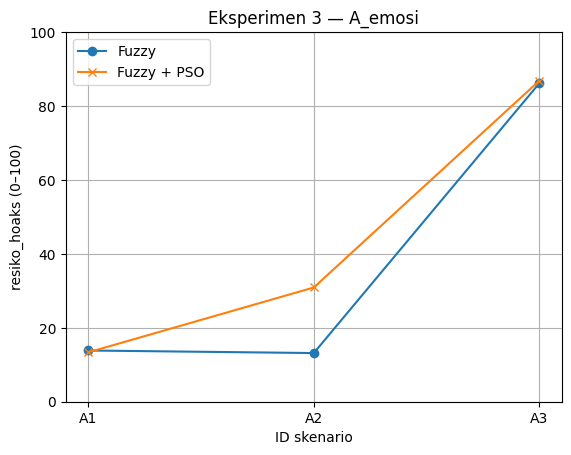

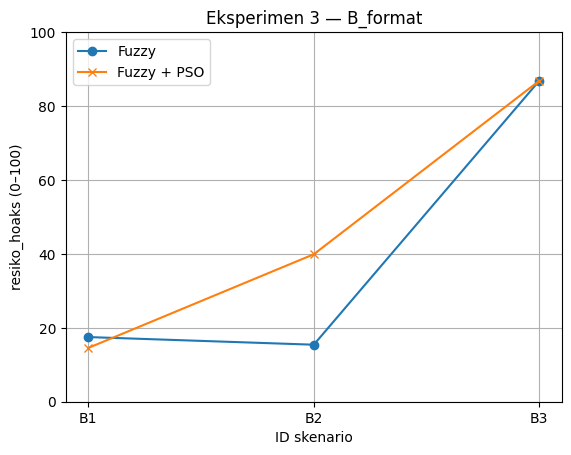

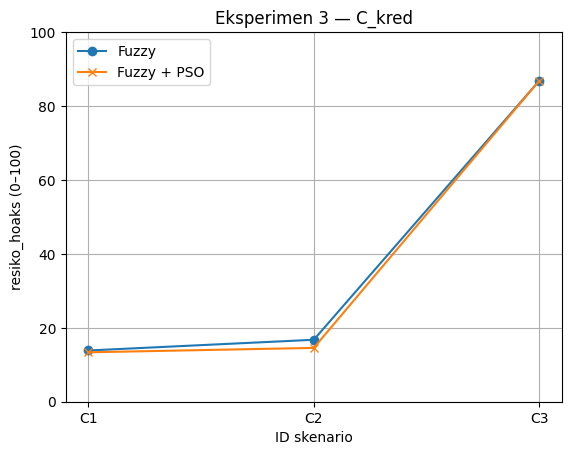

In [12]:
# Cell 7 — plot per kelompok (opsional, untuk visualisasi sensitivity)

import matplotlib.pyplot as plt
import numpy as np

for g, dfg in df_skenario.groupby("kelompok"):
    plt.figure()
    x = np.arange(len(dfg))
    plt.plot(x, dfg["resiko_fuzzy"], marker="o", label="Fuzzy")
    plt.plot(x, dfg["resiko_fuzzy_pso"], marker="x", label="Fuzzy + PSO")
    plt.xticks(x, dfg["id"])
    plt.ylim(0, 100)
    plt.xlabel("ID skenario")
    plt.ylabel("resiko_hoaks (0–100)")
    plt.title(f"Eksperimen 3 — {g}")
    plt.grid(True)
    plt.legend()
    plt.show()


KeyError: 'Kelompok'

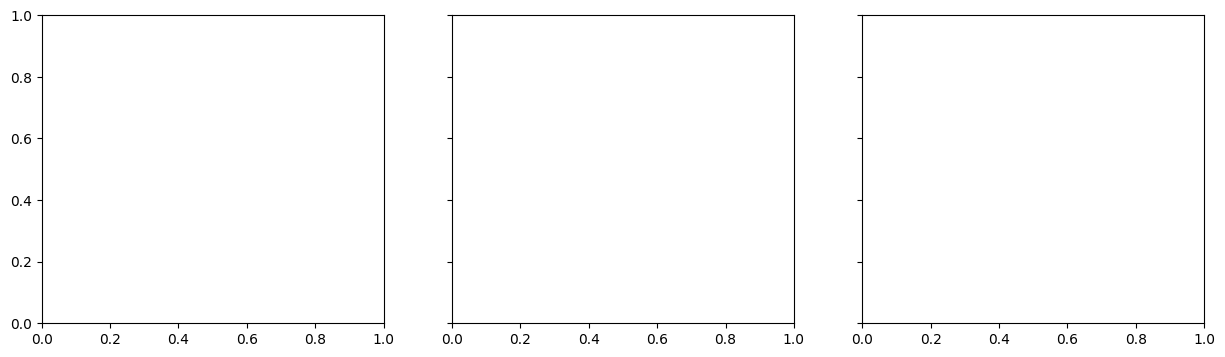

In [13]:
import matplotlib.pyplot as plt

# Pastikan df_skenario sudah ada

groups = ["A_emosi", "B_format", "C_kred"]
titles = ["Eksperimen 3 — A_emosi",
          "Eksperimen 3 — B_format",
          "Eksperimen 3 — C_kred"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for ax, grp, title in zip(axes, groups, titles):
    dfg = df_skenario[df_skenario["Kelompok"] == grp]

    ax.plot(dfg["ID"], dfg["resiko_fuzzy"],
            marker="o", linestyle="-", label="Fuzzy")
    ax.plot(dfg["ID"], dfg["resiko_fuzzy_pso"],
            marker="x", linestyle="--", label="Fuzzy + PSO")

    ax.set_title(title)
    ax.set_xlabel("ID skenario")
    ax.grid(True)
    ax.set_ylim(0, 100)

axes[0].set_ylabel("resiko_hoaks (0–100)")

# Legend gabungan di atas tengah
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2)

fig.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()
